# Energy Deposits per Detector Cell
---

The goal of this notebook is to help answer the following question: *How often in a given cell does BIB get in the way of reconstructing the particles we want to look at?*

To do so, we'll try to plot energy deposits per detector cell.

In [1]:
import ROOT as rt
import ctypes
import numpy as np

# rt.EnableImplicitMT(1)  # Multithreading
# rt.gEnv.Print()         # View ROOT properties

Welcome to JupyROOT 6.24/06


In [2]:
# %%bash
# rootls -l /work/rhillman/Data/photonGun_1000_reco_990.root

In [3]:
treename = "events"
filename = "/work/rhillman/Data/photonGun_1000_reco_970.root"
df = rt.RDataFrame(treename, filename)

In [4]:
%%cpp
events->Print("ECalBarrel*")

******************************************************************************
*Chain   :events    : /work/rhillman/Data/photonGun_1000_reco_970.root       *
******************************************************************************
******************************************************************************
*Tree    :events    : events data tree                                       *
*Entries :       10 : Total =       138031523 bytes  File  Size =   62650810 *
*        :          : Tree compression factor =   2.20                       *
******************************************************************************
*Br    0 :ECalBarrelCollection : Int_t ECalBarrelCollection_                 *
*Entries :       10 : Total  Size=       6193 bytes  File Size  =        274 *
*Baskets :        2 : Basket Size=      32000 bytes  Compression=   1.00     *
*............................................................................*
*Br    1 :ECalBarrelCollection.cellID : ULong_t cell

Warning in <TClass::Init>: no dictionary for class edm4hep::TrackerHitPlaneData is available
Warning in <TClass::Init>: no dictionary for class edm4hep::Vector2f is available
Warning in <TClass::Init>: no dictionary for class edm4hep::Quantity is available
Warning in <TClass::Init>: no dictionary for class podio::version::Version is available


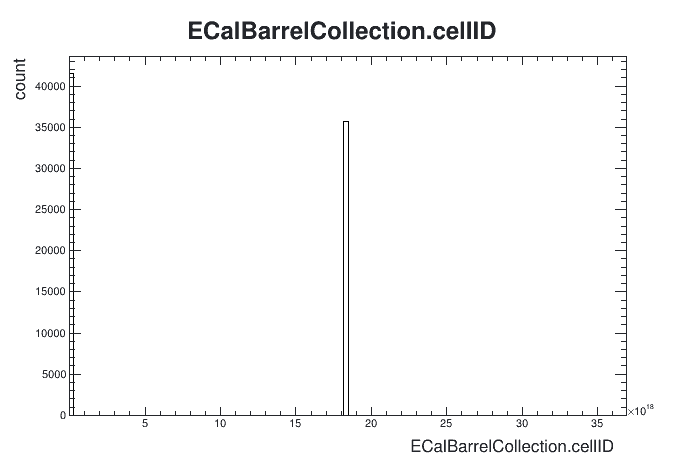

In [5]:
# %jsroot on
# def plot(model, column):
#     c = rt.TCanvas()
#     h = rt.Histo1D(model, column)
#     h.Draw()
#     c.Draw()

c = rt.TCanvas()
h = df.Histo1D("ECalBarrelCollection.cellID")
h.Draw()
c.Draw()

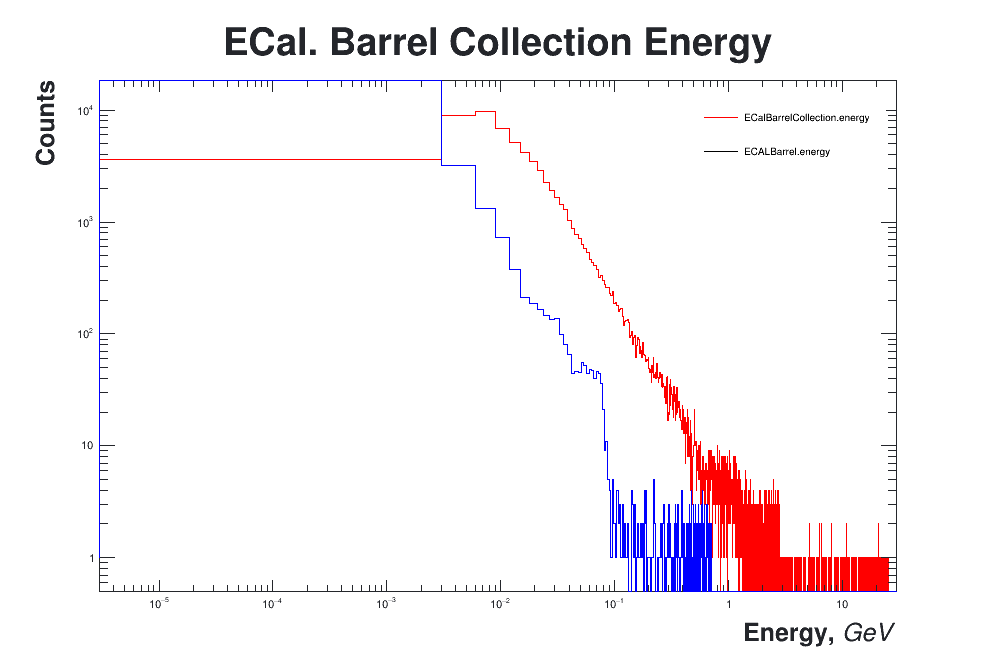

In [6]:
# %jsroot on

nbins = 10000
c = rt.TCanvas("c96", "1-D Histograms", 1000, 700)
h = df.Histo1D(("h1", "ECal. Barrel Collection Energy;#bf{Energy,} #it{GeV};#bf{Counts}", nbins, 0, 30), "ECALBarrel.energy")
h2 = df.Histo1D(("h1", "ECal. Barrel Collection Energy;#bf{Energy,} #it{GeV};#bf{Counts}", nbins, 0, 30), "ECalBarrelCollection.energy")
h.SetLineColor(rt.kRed)
h.Draw("")
h2.SetLineColor(rt.kBlue)
h2.Draw("same")
c.SetLogy()
c.SetLogx()
legend = rt.TLegend(.7,.75,.89,.85)
legend.SetBorderSize(0)
legend.AddEntry("h1", "ECalBarrelCollection.energy", "L")
legend.AddEntry("h2", "ECALBarrel.energy", "L")
legend.Draw()
c.Draw()

In [7]:
# # Weight all bins by their energy content
# c = rt.TCanvas()
# h2 = h.Clone("h2")

# print(h.GetBinCenter(1))
# for ibin in range(1, nbins+1):
#     E_weighted = h.GetBinContent(ibin)*h.GetBinCenter(ibin)
#     h2.SetBinContent(ibin, E_weighted)
    
# h2.Draw("")
# # c.SetLogy()
# # c.SetLogx()
# c.Draw()

How much of the total energy can you retain as a function of minimum energy threshold?

## New Histogram Loop
Trying to get this to work...

77201.0
77201.0
3644.0


8515.944982626825

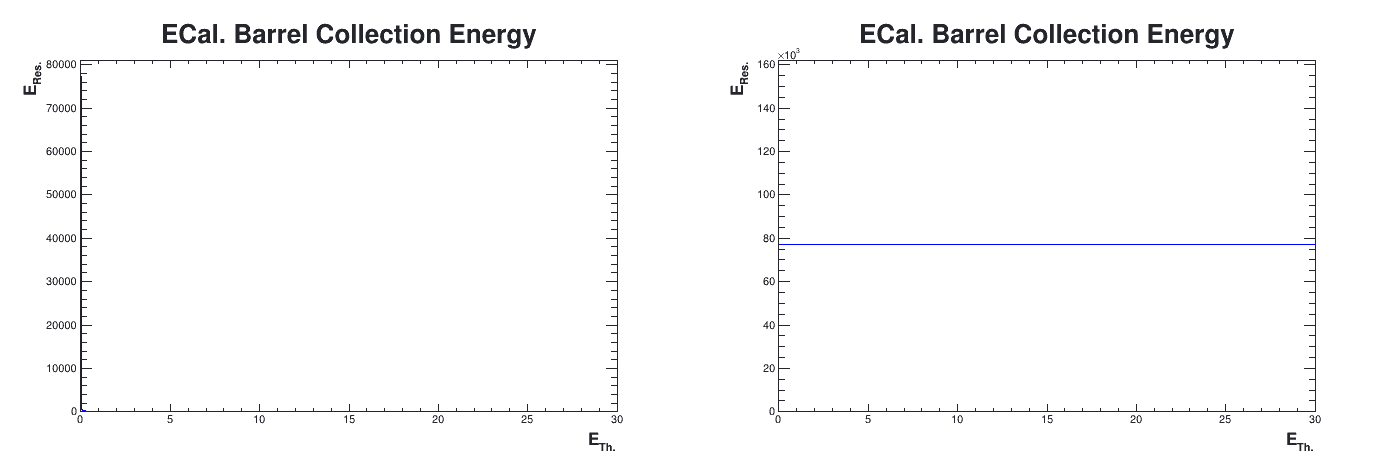

In [8]:
c = rt.TCanvas("c", "1-D Histograms", 1400, 500)
c.Divide(2,1)
# c.SetLogx()
# c.SetLogy()
hthr = h2.Clone("hthr")

hthr.GetYaxis().SetTitle("#bf{E_{Res.}}")
hthr.GetXaxis().SetTitle("#bf{E_{Th.}}")

htotal = hthr.Clone("htotal")

error1 = ctypes.c_double(0)
Ebin1 = h2.IntegralAndError(1, nbins, error1)
for ibin in range(1, nbins+2):
    error2 = ctypes.c_double(0)
    E = h2.IntegralAndError(ibin, nbins, error2)
    htotal.SetBinContent(ibin, Ebin1)
    hthr.SetBinContent(ibin, E)

c.cd(1)
hthr.SetFillColorAlpha(rt.TColor().GetColor(193, 146, 80), 1)
hthr.SetFillStyle(3004)
hthr.Draw("")
c.cd(2)
hthr.SetFillColorAlpha(rt.kBlue, .5)
htotal.Draw("")
c.Draw()

print(hthr.GetBinContent(1))
print(htotal.GetBinContent(50))
print(h.GetBinContent(1))
df.Sum("ECALBarrel.energy").GetValue()

Info in <TCanvas::Print>: png file eff.png has been created


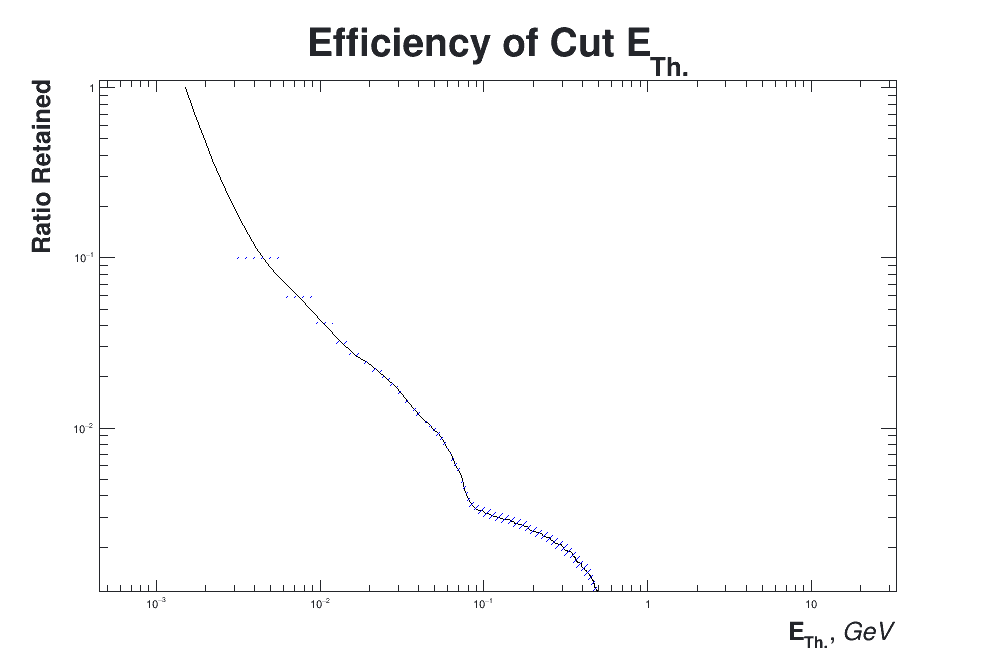

In [9]:
c = rt.TCanvas("c97", "1-D Histograms", 1000, 700)
eff = rt.TEfficiency(hthr, htotal)
eff = eff.CreateGraph()
eff.SetTitle("Efficiency of Cut E_{Th.}")
eff.GetXaxis().SetTitle("#bf{E_{Th.}}, #it{GeV}")
eff.GetXaxis().SetRangeUser(0, 30)
eff.GetYaxis().SetTitle("#bf{Ratio Retained}")
eff.GetYaxis().SetRangeUser(0, 30)
eff.SetFillStyle(3004)
eff.SetFillColor(600)
eff.SetLineColor(rt.kBlack)
c.SetLogy()
c.SetLogx()
eff.Draw('a2c')
c.Print("eff.png")
c.Draw()

## Numba with ROOT

Numba allows you to employ pythonic operations in ROOT C++. This is useful for defining new columns, which typically requires using C++ syntax (which I don't know well).

In [10]:
@rt.Numba.Declare(['float', 'int'], "float")    # Supply I/O types
def pypow(x, y):    # Declare functions
    return x**y

In [11]:
%%cpp
cout << "2^3 = " << Numba::pypow() << endl; # Call in C++

input_line_187:2:35: error: too few arguments to function call, expected 2, have 0
 cout << "2^3 = " << Numba::pypow() << endl; # Call in C++
                     ~~~~~~~~~~~~ ^
input_line_186:5:1: note: 'pypow' declared here
float pypow(float x_0, int x_1) {
^
input_line_187:2:46: error: expected expression
 cout << "2^3 = " << Numba::pypow() << endl; # Call in C++
                                             ^


In [12]:
@rt.Numba.Declare(['float', 'float'], "bool")
def isAboveThreshold(threshold, value):
    return value > threshold

@rt.Numba.Declare(['float', 'float'], "bool")
def isNotAboveThreshold(threshold, value):
    return value <= threshold

In [13]:
h = h.GetEntries()
print(h)

70892.0
